0.0


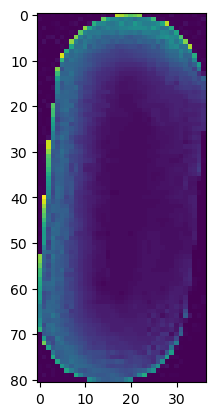

In [30]:
## Shape mathcing for filtering masks
# https://docs.opencv.org/4.x/d5/d45/tutorial_py_contours_more_functions.html#:~:text=OpenCV%20comes%20with%20a%20function,on%20the%20hu%2Dmoment%20values.

import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('images/raw_4/cuts_out_6.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('database/shape/s6.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1)

ret, thresh = cv2.threshold(img1, 1, 1,0)
ret, thresh2 = cv2.threshold(img2, 1, 1,0)

blank1 = np.ones((thresh.shape[0], thresh.shape[1]))
blank2 = np.ones((thresh2.shape[0], thresh2.shape[1]))
# plt.imshow(thresh)

contours,hierarchy = cv2.findContours(thresh,2,1)
cv2.drawContours(thresh, contours, -1, color=(0, 0, 255), thickness=6)
# plt.imshow(blank1)
contours,hierarchy = cv2.findContours(thresh2,2,1)
cv2.drawContours(thresh2, contours, -1, color=(0, 0, 255), thickness=6)
# plt.imshow(thresh2)
ret = cv2.matchShapes(thresh,thresh2,cv2.CONTOURS_MATCH_I1,0.0)
print(ret)

In [2]:
def sobel_convolution(img):
  # Convert to grayscale if not already
  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Apply sobel kernels and compute gradient magnitude
  G = np.hypot(cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3),cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3))
  # Normalize and convert to uint8
  G = (G / G.max() * 255).astype(np.uint8)
  # Return the output G
  return G

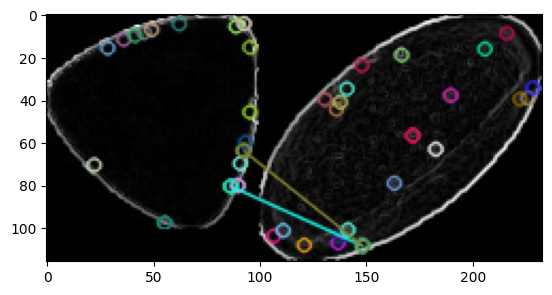

2


In [15]:
# Scale Invariant feature 

# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img1 = cv2.imread('database/shape/s6.jpg', cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread('database/shape/s6.jpg', cv2.IMREAD_GRAYSCALE)

MIN_MATCH_COUNT = 6

img1 = cv2.imread('database/color/c1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('cuts_out/cuts_out_1.jpg', cv2.IMREAD_GRAYSCALE)

# # Call the function and get the output G
img1 = sobel_convolution(img1)
img2 = sobel_convolution(img2)

# Initiate SIFT detector
# contrastThreshold=0.05, edgeThreshold=20
sift = cv2.SIFT_create()

# detect and compute the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = [] 
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

 # Extract source and destination points
src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)
    
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,None)
plt.imshow(img3, 'gray'),plt.show()
print(len(good))

In [9]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    print(len( matchesMask))
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

NameError: name 'good' is not defined

In [10]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

NameError: name 'matchesMask' is not defined

In [61]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

AttributeError: 'tuple' object has no attribute 'queryIdx'

In [4]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color

# Read image
img1 = cv2.imread('database/color/c3.jpg')
img2 = cv2.imread('cuts_out/cuts_out_1.jpg')

# Define function to compare histograms
def compare_hist(hist1, hist2):
    
    # Chi-squared distance
    return np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + 1e-6))

# Create 3D color histogram
def get_3D_hsv_hist(image):
    
    # Convert to HSV color space
    hsv = skimage.color.rgb2hsv(image)

    # Create 3D color histogram
    hist, edges = np.histogramdd(hsv.reshape(-1, 3), bins=(8, 8, 8))

    # Normalize histogram
    hist /= hist.sum()
    
    return hist
    
    
compare_hist(get_3D_hsv_hist(img1),get_3D_hsv_hist(img2))

1.4052856091566182

In [17]:
# Define a function to rotate an image for n times and save them in a list
def rotate_image(img, n):
  # Create an empty list to store the rotated images
  rotated_imgs = []
  # Loop from 0 to n-1
  for i in range(n):
    # Rotate the image by 90 degrees clockwise
    h, w = img.shape[:2]
    # Convert the angle from radians to degrees
    angle = np.rad2deg(np.pi*i/n)
    # Calculate the center of the image
    center = (w/2, h/2)
    # Get the rotation matrix from the angle and center
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Apply the affine transformation to the image
    rotated_img = cv2.warpAffine(img, M, (w, h))
    # Append the rotated image to the list
    rotated_imgs.append(rotated_img)
  # Return the list of rotated images
  return rotated_imgs

In [18]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define function to compare histograms
def compare_hist(hist1, hist2):
    
    # Chi-squared distance
    return np.sum((hist1 - hist2) ** 2 / (hist1 + hist2 + 1e-6))

# Load the image database
images = []
feature_list = []
labels = []
for i in range(5):
    # Load the image and resize it to 64x64 pixels
    raw_img = cv2.imread(f"database/color/c{i}.jpg")
    rotated_imgs = rotate_image(raw_img, 8)
    images.append(raw_img)
    features_rot = []  
    for img in rotated_imgs:
        img = cv2.resize(img, (64, 64))
        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Compute the HOG features using 8x8 cells and 9 orientations
        hog = cv2.HOGDescriptor((64, 64), (8, 8), (8, 8), (8, 8), 9)
        features = hog.compute(img)
        # Flatten the features vector
        # features = features.ravel()
        features /= features.sum()
        features_rot.append(features)
    # Append the features and the label to the lists
    feature_list.append(features_rot)
    labels.append(i)

# Load the query image and resize it to 64x64 pixels
query = cv2.imread('cuts_out/cuts_out_7.jpg')
query = cv2.resize(query, (64, 64))
# Convert the query image to grayscale
query = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)
# Compute the HOG features using 8x8 cells and 9 orientations
query_features = hog.compute(query)
# Flatten the features vector
# query_features = query_features.ravel()
query_features /= query_features.sum()

# Initialize a list to store the chi-square distances
distances = []
# Loop over the images in the database
for features_rot in feature_list:
    chi_dist_list = []
    for features in features_rot:
        # Calculate the chi-square distance between the query and the image features
        chi_dist_list.append(compare_hist(query_features, features))
        # Append the distance to the list
    distances.append(min(chi_dist_list))

# Find the index of the minimum distance in the list
min_index = np.argmin(distances)
print(distances)
# Print the prediction
# print(f"The query image matches with c{labels[min_index]}.jpg")
plt.imshow(query)
plt.imshow(images[labels[min_index]])


[ WARN:0@1104.759] global loadsave.cpp:244 findDecoder imread_('cuts_out/cuts_out_7.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [19]:
def register_hog_db():
    pill_db = []
    # Compute the HOG features using 8x8 cells and 9 orientations
    hog = cv2.HOGDescriptor((64, 64), (8, 8), (8, 8), (8, 8), 9)
    for i in range(5):
        temp_l = []        
        for j in range(3):
            img = cv2.imread('database/pill_db/p{}_{}.jpg'.format(i,j))
            img = cv2.resize(img, (64, 64))
            # Convert the image to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            features = hog.compute(img)
            # Flatten the features vector
            # features = features.ravel()
            features /= features.sum()
            temp_l.append(features)
        pill_db.append(temp_l)
    return pill_db

In [29]:
pill_db = []
# Compute the HOG features using 8x8 cells and 9 orientations
hog = cv2.HOGDescriptor((64, 64), (8, 8), (8, 8), (8, 8), 9)
for i in range(5):
    temp_l = []        
    for j in range(3):
        img = cv2.imread('database/pill_db/p{}_{}.jpg'.format(i,j))
        img = cv2.resize(img, (64, 64))
        # Convert the image to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features = hog.compute(img)

In [70]:
from skimage.feature import hog
img = cv2.imread('database/pill_db/p4_4.jpg')
resized_img = cv2.resize(img, (64, 64))
input_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
fd, hog_image = hog(input_img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)


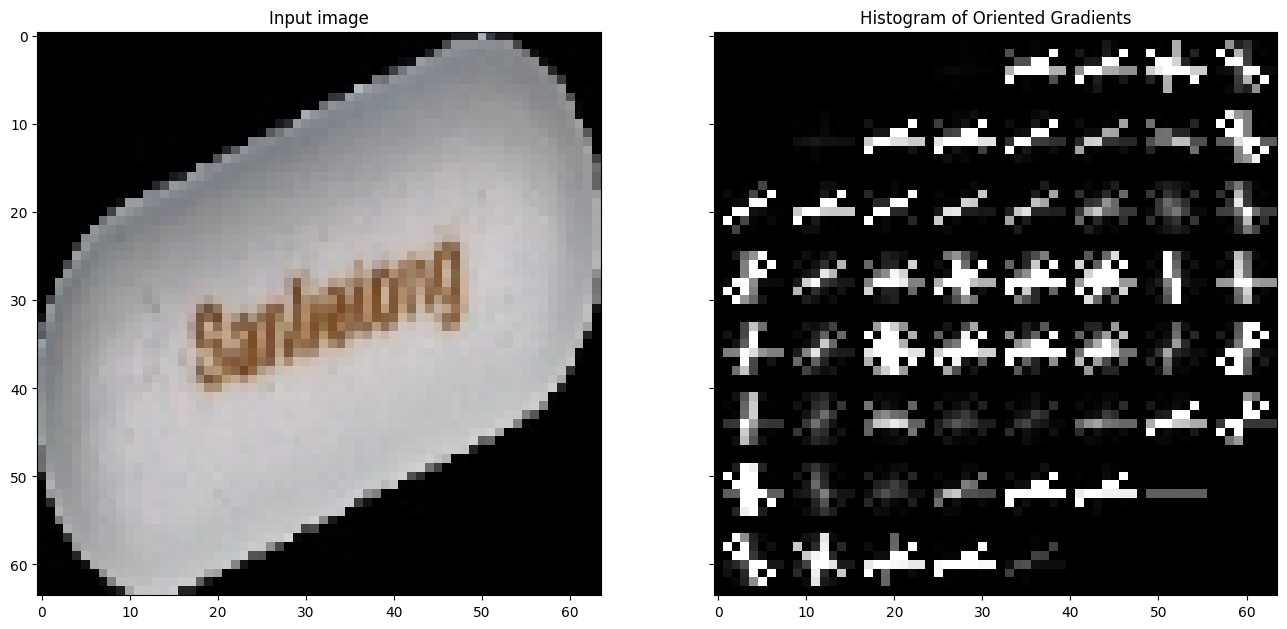

In [71]:
from skimage import exposure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()